In [ ]:
# Import packages and set up sessions

In [34]:
import boto3
import sagemaker
from sagemaker import get_execution_role

# Initialize SageMaker session and role
sagemaker_session = sagemaker.Session()
bucket = 'adith-product-demand-forecast'
role = get_execution_role()
region = sagemaker_session.boto_region_name


In [ ]:
# Define s3 paths

In [36]:
prefix = 'raw'  # since your `train.csv` is in the raw folder
train_data_s3_path = f's3://{bucket}/{prefix}/train.csv'


In [ ]:
# Step 5: Define the Estimator

In [37]:
from sagemaker.estimator import Estimator

image_uri = sagemaker.image_uris.retrieve(
    framework='forecasting-deepar',
    region=region
)

deepar_estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/deepar/output',
    base_job_name='deepar-forecast',
    sagemaker_session=sagemaker_session
)

deepar_estimator.set_hyperparameters(
    time_freq='D',
    context_length='30',
    prediction_length='30',
    epochs='50',
    mini_batch_size='64',
    num_cells='40',
    num_layers='2',
    likelihood='gaussian',
    early_stopping_patience='5',
)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [ ]:
# Step 6: Train the Model

In [38]:
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=f's3://{bucket}/deepar/train',
    content_type="json"  # not "application/json"
)

deepar_estimator.fit({'train': train_input}, wait=True)


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: deepar-forecast-2025-07-25-04-54-17-066


2025-07-25 04:54:18 Starting - Starting the training job...
2025-07-25 04:54:52 Downloading - Downloading input data......
2025-07-25 04:55:37 Downloading - Downloading the training image............
2025-07-25 04:57:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[07/25/2025 04:57:50 INFO 140591906740032] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood'

In [ ]:
# Step 7: Deploy the trained model to an endpoint

In [39]:
predictor = deepar_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="deepar-forecast-endpoint"
)

INFO:sagemaker:Creating model with name: deepar-forecast-2025-07-25-05-03-49-218
INFO:sagemaker:Creating endpoint-config with name deepar-forecast-endpoint
INFO:sagemaker:Creating endpoint with name deepar-forecast-endpoint


---------!

Payload preview:
 {
  "instances": [
    {
      "start": "2017-05-18 00:00:00",
      "target": [
        2600.0,
        3077.0,
        2573.0,
        1205.0,
        2842.0,
        2665.0,
        3574.0,
        2505.0,
        1301.0,
        2166.0,
        1258.0,
        2666.0,
        2497.0,
        3262.0,
        2774.0,
        2953.0,
        2996.0,
        1148.0,
        3071.0,
        3383.0,
        3353.0,
        2902.0,
        3105.0,
        3106.0,
        1352.0,
        2601.0,
        2426.0,
        4411.0,
        3189.0,
        2991.0,
        3016.0,
        1223.0,
        3373.0,
        4575.0,
        2898.0,
        2499.0,
        2663.0,
        2877.0,
        1264.0,
        2812.0,
        2653.0,
        3003.0,
        2603.0,
        2916.0,
        2871.0,
        1222.0,
        2952.0,
        2759.0,
        3147.0,
        2550.0,
        2972.0,
        2561.0,
        1140.0,
        2849.0,
        2712.0,
        3185.0,
     

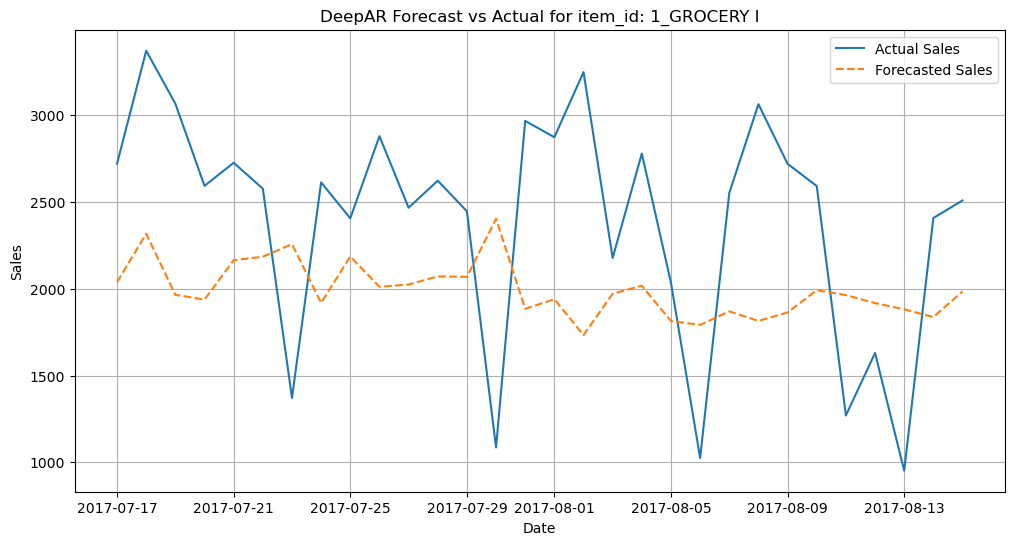

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Step 8: Load the cleaned training data from S3
df = pd.read_csv("s3://adith-product-demand-forecast/raw/train.csv")

# Step 9: Filter to a single item_id for testing
df['item_id'] = df['store_nbr'].astype(str) + "_" + df['family']
df['timestamp'] = pd.to_datetime(df['date'])
df = df.rename(columns={"sales": "target_value"})

# Select the item to forecast
sample_item_id = "1_GROCERY I"
item_df = df[df["item_id"] == sample_item_id].sort_values("timestamp")

# Step 10: Prepare payload for DeepAR (without 'cat' key since model wasn't trained with it)
prediction_length = 30
context_length = 60

test_series = {
    "start": item_df["timestamp"].iloc[-(context_length + prediction_length)].strftime("%Y-%m-%d %H:%M:%S"),
    "target": item_df["target_value"].iloc[-(context_length + prediction_length):-prediction_length].tolist()
}

payload = {
    "instances": [test_series],
    "configuration": {"num_samples": 100}
}

# Optional: print preview to confirm
print("Payload preview:\n", json.dumps(payload, indent=2))

# Step 11: Set up the predictor
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name="deepar-forecast-endpoint",  # use your actual endpoint name
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

# Step 12: Call the endpoint
response = predictor.predict(payload)

# Step 13: Extract mean forecast
forecast_mean = response["predictions"][0]["mean"]

# Step 14: Plot actual vs forecast
actual = item_df["target_value"].iloc[-prediction_length:].tolist()
dates = item_df["timestamp"].iloc[-prediction_length:]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates, actual, label="Actual Sales")
plt.plot(dates, forecast_mean, label="Forecasted Sales", linestyle="--")
plt.title(f"DeepAR Forecast vs Actual for item_id: {sample_item_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()